Name : Saarthak Khamkar   
Roll No. : D088   
SAP ID : 60009230057

#Anomaly Detection using Self-Organizing Network

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from minisom import MiniSom
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

In [16]:
data_path = "Credit_Card_Applications.csv"
df = pd.read_csv(data_path)

print("Shape:", df.shape)
print("\nColumns:", list(df.columns))

Shape: (690, 16)

Columns: ['CustomerID', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'Class']


In [17]:
# Drop CustomerID column (if present)
id_col = None
for col in df.columns:
    if 'id' in col.lower() or 'customer' in col.lower():
        id_col = col
        break

if id_col:
    print(f"\nDropping ID column: {id_col}")
    df = df.drop(columns=[id_col])

# Drop class/label column (SOM is unsupervised)
class_col = None
for col in df.columns:
    if df[col].nunique() == 2 and df[col].dtype != object:
        class_col = col
        break

if class_col:
    print(f"Dropping class/label column: {class_col}")
    df_features = df.drop(columns=[class_col])
else:
    df_features = df.copy()

# Handle non-numeric data (if any)
for c in df_features.select_dtypes(include=['object']).columns:
    df_features[c] = df_features[c].astype('category').cat.codes

# Normalize the data
scaler = MinMaxScaler()
X = scaler.fit_transform(df_features)


Dropping ID column: CustomerID
Dropping class/label column: A1


In [18]:
# Hyperparameters (tuned empirically)
som_grid_rows = 10
som_grid_columns = 10
sigma = 1.0
learning_rate = 0.5
num_iterations = 2000

print(f"\nTraining SOM with grid {som_grid_rows}x{som_grid_columns} ...")

som = MiniSom(x=som_grid_rows, y=som_grid_columns, input_len=X.shape[1],
              sigma=sigma, learning_rate=learning_rate,
              neighborhood_function='gaussian', random_seed=42)
som.random_weights_init(X)
som.train_random(X, num_iterations)

print("SOM Training Completed!")


Training SOM with grid 10x10 ...
SOM Training Completed!


In [19]:
# ==============================
# DETECT ANOMALIES
# ==============================

# Compute the distance map (U-Matrix)
u_matrix = som.distance_map()

# Each sample's BMU (Best Matching Unit)
bmus = np.array([som.winner(x) for x in X])

# Get U-Matrix values for BMUs (used as anomaly score)
bmu_u_vals = np.array([u_matrix[bmu] for bmu in bmus]).flatten()[:len(X)]

# Anomaly threshold (tuneable)
threshold = 0.85 * u_matrix.max()

# Boolean mask for anomalies
anomaly_flags = np.array(bmu_u_vals >= threshold).flatten()[:len(X)]

# Extract suspected frauds
suspected_frauds = df[anomaly_flags]
print(f"\nNumber of suspected frauds: {len(suspected_frauds)}")

# Save to CSV
suspected_frauds.to_csv("suspected_frauds_som.csv", index=False)
print("Suspected frauds saved to suspected_frauds_som.csv")


Number of suspected frauds: 66
Suspected frauds saved to suspected_frauds_som.csv


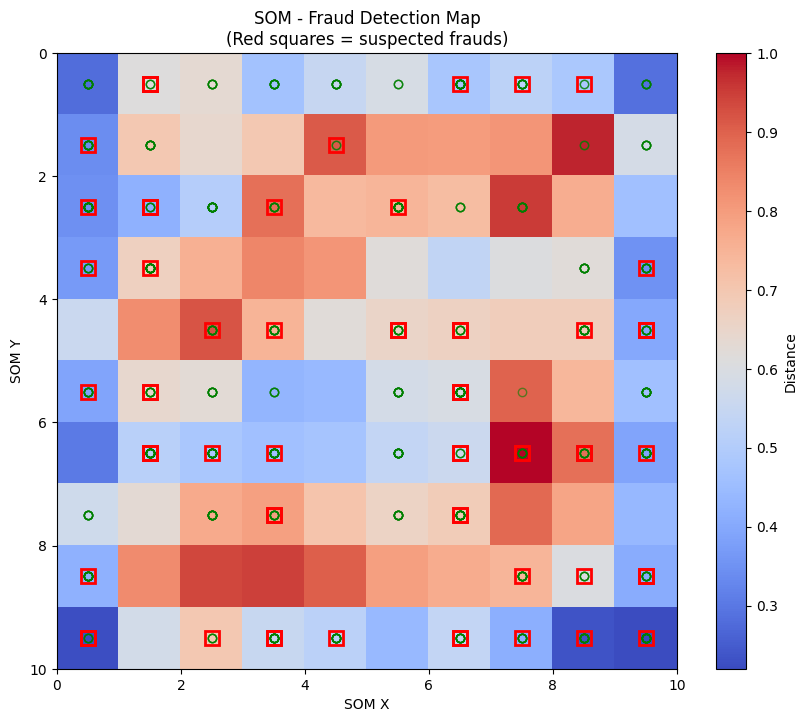

In [20]:
# ==============================
# VISUALIZATION
# ==============================

plt.figure(figsize=(10, 8))
plt.pcolor(u_matrix.T, cmap='coolwarm')  # U-Matrix (distance map)
plt.colorbar(label='Distance')

# Markers: red squares = suspected frauds, green circles = normal
for i, x in enumerate(X):
    w = som.winner(x)
    if anomaly_flags[i]:
        plt.plot(w[0] + 0.5, w[1] + 0.5, 's', markerfacecolor='none',
                 markeredgecolor='r', markersize=10, markeredgewidth=2)
    else:
        plt.plot(w[0] + 0.5, w[1] + 0.5, 'o', markerfacecolor='none',
                 markeredgecolor='g', markersize=6, alpha=0.6)

plt.title("SOM - Fraud Detection Map\n(Red squares = suspected frauds)")
plt.xlabel("SOM X")
plt.ylabel("SOM Y")
plt.gca().invert_yaxis()
plt.show()

In [21]:
print("\nTop 10 suspected fraud records:")
print(suspected_frauds.head(10).to_string(index=False))


Top 10 suspected fraud records:
 A1    A2     A3  A4  A5  A6    A7  A8  A9  A10  A11  A12  A13  A14  Class
  1 23.42  1.000   2   8   4 0.500   0   0    0    1    1  280    1      0
  1 34.17  5.250   2   9   4 0.085   0   0    0    1    2  290    7      1
  0 18.17 10.000   1  11   8 0.165   0   0    0    0    2  340    1      0
  0 17.33  9.500   2   6   4 1.750   0   1   10    1    2    0   11      0
  1 33.58  0.250   2   3   5 4.000   0   0    0    1    1  420    1      0
  1 22.75 11.000   2  11   4 2.500   1   1    7    1    2  100  810      1
  0 31.25  3.750   2  13   8 0.625   1   1    9    1    2  181    1      1
  0 46.00  4.000   2   5   3 0.000   1   0    0    0    2  100  961      1
  1 43.08  0.375   1   8   4 0.375   1   1    8    1    2  300  163      1
  1 17.92  0.205   2   6   4 0.040   0   0    0    0    2  280  751      0


Colab Link : https://colab.research.google.com/drive/1ZO4aZ2-J_TixUeOPpBX085uELxD1m3p1?usp=sharing